In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**0. Other Methodolgy**

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 5.3 MB/s 


In [ ]:
import pylab as plt
import numpy as np

from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint

x, _, _, _ = load_gunpoint(return_X_y=True)
print(x.shape)

In [ ]:
RP = RecurrencePlot(dimension=3, time_delay=4)

In [ ]:
import csv

def preprocess(path_csv):
  f = open(path_csv, 'r', encoding='utf-8')
  rdr = csv.reader(f)
  data = list()
  for i, line in enumerate(rdr):
    if i == 300:
      break
    # classfication, time series
    cl, ts = line[0], line[1:]
    cl = float(cl) - 1
    ts = list(map(float, ts))
    data.append(ts)
  data = np.array(data)
  data = RP.transform(data)
  f.close()
  return data

(418, 418)


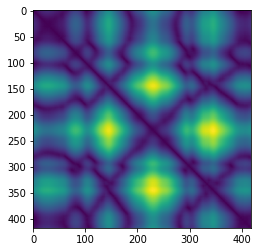

In [ ]:
path_train = 'drive/MyDrive/Notebooks/UCR/yoga/yoga_TRAIN_copy.csv'
path_test = 'drive/MyDrive/Notebooks/UCR/yoga/yoga_TEST_copy.csv'
train_data = preprocess(path_train)
test_data = preprocess(path_test)[:300]

img = train_data[0]
print(img.shape)
plt.imshow(img)
plt.show()

**1. Define Recurrence Plot algorithm.**

In [ ]:
def rec_plot(s, eps=0.01, steps=10):
  N = s.size
  S = np.repeat(s[None, :], N, axis=0)
  Z = np.floor(np.abs(S - S.T) / eps)
  Z[Z > steps] = steps
  return Z

**2. Define Preprocessing function.**

In [ ]:
import csv

def preprocess(path_csv):
  f = open(path_csv, 'r', encoding='utf-8')
  rdr = csv.reader(f)
  data = list()
  for i, line in enumerate(rdr):
    if i == 300:
      break
    # classfication, time series
    cl, ts = line[0], line[1:]
    cl = float(cl) - 1
    ts = list(map(float, ts))
    ts = np.array(ts)
    ts = rec_plot(ts, 0.1, 100)
    tensor = np.array([ts]) # 1, 426, 426
    data.append((cl, ts, tensor))
  f.close()
  return data

(426, 426)


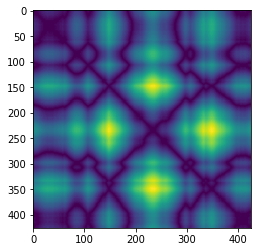

In [ ]:
path_train = 'drive/MyDrive/Notebooks/UCR/yoga/yoga_TRAIN_copy.csv'
path_test = 'drive/MyDrive/Notebooks/UCR/yoga/yoga_TEST_copy.csv'
train_data = preprocess(path_train)
test_data = preprocess(path_test)[:300]

cl, ts, tensor = train_data[0] 
print(ts.shape)
plt.imshow(ts)
plt.show()

**3-1. Define Vanilla CNN.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(1, 32, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )

    # Fully Connected Layers
    self.fc = nn.Linear(32 * 105 * 105, 2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x) # torch.Size([3, 32, 105, 105])
    x = x.view(-1, 32 * 105 * 105)
    x = self.fc(x)

    return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN()
net.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=352800, out_features=2, bias=True)
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

feature_blobs = []

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(1, 64, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(64, 128, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(128, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(256, 512, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    # Fully Connected Layers
    self.clf = nn.Linear(512, 2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    # x = x.view(x.size(0), -1)
    x = torch.flatten(x, 1)
    x = self.clf(x)

    return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN()
net.to(device)

**3-2. Define Advanced CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

feature_blobs = []

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(1, 64, 3),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(64, 128, 3),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(128, 256, 3),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(256, 512, 3),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(512, 1024, 3),
        nn.LeakyReLU(),
        nn.MaxPool2d(2, 2)
    )

    # layer6? [5, 2048, 4, 4]

    # Global Average Pooling
    # self.global_avg = nn.AdaptiveAvgPool2d(1)

    # Global Max Pooling
    self.global_max = nn.AdaptiveMaxPool2d(1)

    # Fully Connected Layers
    self.clf = nn.Linear(1024, 2)

    # self.sm = nn.LogSoftmax(1)

  def forward(self, x):
    # print(x.shape)  # torch.Size([5, 1, 426, 426])
    x = self.layer1(x)
    # print(x.shape)  # torch.Size([5, 64, 212, 212])
    x = self.layer2(x)
    # print(x.shape)  # torch.Size([5, 128, 105, 105])
    x = self.layer3(x)
    # print(x.shape)  # torch.Size([5, 256, 51, 51])
    x = self.layer4(x)
    # print(x.shape, '\n')  # torch.Size([5, 512, 24, 24]) 
    x = self.layer5(x)
    # [5, 1024, 11, 11]

    if not len(feature_blobs):
      feature_blobs.append(x)

    # x = self.global_avg(x)
    x = self.global_max(x)
    # x = x.view(x.size(0), -1)
    x = torch.flatten(x, 1)
    x = self.clf(x)
    # x = self.sm(x)

    return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN()
net.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

**4. Define loss function.**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(),
                      lr=0.0005,
                      momentum=0.9)

**5. Define and initialize custom dataset class.**

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self, X: list, y: list):
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
# tensor, cl
train_X = [data[2] for data in train_data]
train_y = [data[0] for data in train_data]
train_dataset = CustomDataset(train_X, train_y)

test_X = [data[2] for data in test_data]
test_y = [data[0] for data in test_data]
test_dataset = CustomDataset(test_X, test_y)

**6. Train & Test dataset**

In [ ]:
epochs = 60
dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

for epoch in range(epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(dataloader):
    optimizer.zero_grad()
    inputs = inputs.float().cuda()
    labels = labels.long().cuda()
    outputs = net(inputs)

    # calculate parameters (W, b)
    loss = criterion(outputs, labels) # prediction, answer
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 60 == 59:
      print(f'[{epoch+1}, {i+1}] : {running_loss/100}')
      running_loss = 0.0

[1, 60] : 0.5258136129379273
[2, 60] : 0.5417663840949536
[3, 60] : 0.4246166509389877
[4, 60] : 0.37973823964595793
[5, 60] : 0.37532845318317415
[6, 60] : 0.3730603474378586
[7, 60] : 0.3858919206261635
[8, 60] : 0.3504660326242447
[9, 60] : 0.3414039443433285
[10, 60] : 0.3594072011113167
[11, 60] : 0.3351858404278755
[12, 60] : 0.3277424021065235
[13, 60] : 0.2835122610628605
[14, 60] : 0.2833152183890343
[15, 60] : 0.25601340271532536
[16, 60] : 0.21916526302695274
[17, 60] : 0.2203739130496979
[18, 60] : 0.21628884810954332
[19, 60] : 0.2334012510627508
[20, 60] : 0.17097927026450635
[21, 60] : 0.22745175540447235
[22, 60] : 0.1547719119116664
[23, 60] : 0.1396402610838413
[24, 60] : 0.1481287419050932
[25, 60] : 0.09736595448106528
[26, 60] : 0.11422557231038809
[27, 60] : 0.09410769099369645
[28, 60] : 0.0664430128596723
[29, 60] : 0.05025751370936632
[30, 60] : 0.044726676903665066
[31, 60] : 0.08600126019446179
[32, 60] : 0.049015263095498085
[33, 60] : 0.03235418563708663
[3

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

total = 0
correct = 0

with torch.no_grad():
  net.eval()
  for i, (inputs, labels) in enumerate(dataloader):
    inputs = inputs.float().cuda()
    labels = labels.long().cuda()
    outputs = net(inputs)
    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()

print(f'accuracy : {100 * correct / total}')

accuracy : 75.0


In [ ]:
dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

total = 0
correct = 0

with torch.no_grad():
  net.eval()
  for i, (inputs, labels) in enumerate(dataloader):
    inputs = inputs.float().cuda()
    labels = labels.long().cuda()
    outputs = net(inputs)
    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()

print(f'accuracy : {100 * correct / total}')

accuracy : 80.33333333333333


**6. Implementation of CAM.**

torch.Size([30, 1, 3, 3])
torch.Size([30])
torch.Size([30])
torch.Size([30])
torch.Size([60, 30, 3, 3])
torch.Size([60])
torch.Size([60])
torch.Size([60])
torch.Size([90, 60, 3, 3])
torch.Size([90])
torch.Size([2, 90])
torch.Size([2])


weight_softmax.shape (2, 90)
blob.shape (90, 51, 51)
Original


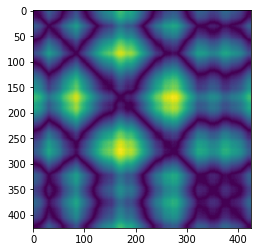

Class 1


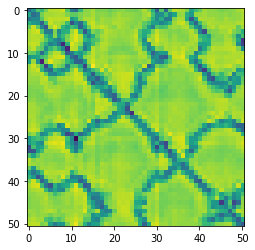

Class 2


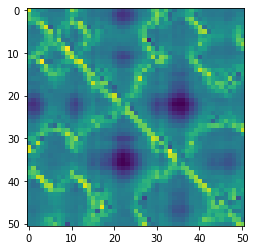

In [ ]:
import cv2
import numpy as np

params = list(net.parameters())
for param in params:
  print(param.shape)
print('\n')
# torch.Size([30, 1, 3, 3])
# torch.Size([30])
# torch.Size([30])
# torch.Size([30])
# torch.Size([60, 30, 3, 3])
# torch.Size([60])
# torch.Size([90, 60, 3, 3])
# torch.Size([90]) # gmp
# torch.Size([2, 90]) # fc
# torch.Size([2]) # softmax

cl, ts, _ = test_data[0]

# get only weight from last layer(linear)
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().data.numpy())
print('weight_softmax.shape', weight_softmax.shape)

# feature_blobs : lists of batchs (Feature map before gmp)
blob: torch.Tensor = feature_blobs[0][0].detach().cpu().numpy()
print('blob.shape', blob.shape) # (90, 51, 51)

def CAM(class_index):
  acc = np.zeros((51, 51))
  ws = weight_softmax[class_index]
  for i, w in enumerate(ws):
    w = float(w)
    b = blob[i]
    acc += (w * b) # broadcasting
  plt.imshow(acc)
  plt.show()

def CAM_V2(class_index):
  ws = weight_softmax[class_index]
  print(ws.shape, blob.shape)
  overlay = np.matmul(ws, blob)
  print(overlay.shape)

# CAM_V2(0)
print('Original')
plt.imshow(ts)
plt.show()
print('Class 1')
CAM(0)
print('Class 2')
CAM(1)